## Import packages + load data

In [1]:
import xarray as xr
import geopandas as gpd
import regionmask
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
rainfall = xr.open_dataset("/g/data/ng72/as9583/agcd_v1_precip_calib_r005_daily_2020.nc") # AGCD calibrated
# rainfall = xr.open_dataset("/g/data/ng72/as9583/agcd_v1_precip_total_r005_daily_2020.nc") #AGCD total 

## Clip data to correct area and coordinate reference system

In [3]:
GDF = gpd.read_file("/g/data/k10/pg1235/abby_smyth_project/STE_2021_AUST_GDA2020.shp") #australia shapefile
gdf=GDF.iloc[[0,7]].geometry;gdf #selecting just NSW and ACT

nsw_act = GDF[GDF["STE_CODE21"].isin(["1", "8"])] #selecting just ACT and NSW 
nsw = nsw_act.dissolve(by="AUS_CODE21").geometry.iloc[0] # and dissolving them

In [4]:
nsw_gdf = gpd.GeoDataFrame(geometry=[nsw], crs=GDF.crs) 

In [5]:
#changing coordinate syst to match
gdf.crs
rainfall = rainfall.rio.write_crs("EPSG:7844")

In [6]:
getbounds = gdf.bounds;getbounds #bounds of the area of NSW and ACT 

,minx,miny,maxx,maxy
0,140.999272,-37.505147,159.109224,-28.156879
7,148.762796,-35.920517,149.399293,-35.124403


In [7]:
lat_min = getbounds.iloc[0,1]  #Minimum latitude
lat_max = getbounds.iloc[0,3]  #Maximum latitude
lon_min = getbounds.iloc[0,0]  #Minimum longitude
lon_max = getbounds.iloc[0,2]  #Maximum longitude

In [8]:
rainbox = rainfall.sel(
    lat=slice(lat_min, lat_max), 
    lon=slice(lon_min, lon_max)
) 

In [9]:
#masking just the area of interest
mask = regionmask.mask_geopandas(
    geodataframe = nsw_gdf,
    lon_or_obj = rainbox.lon.values,
    lat = rainbox.lat.values
)
# mask.plot() 
# plt.show

## Make maps 

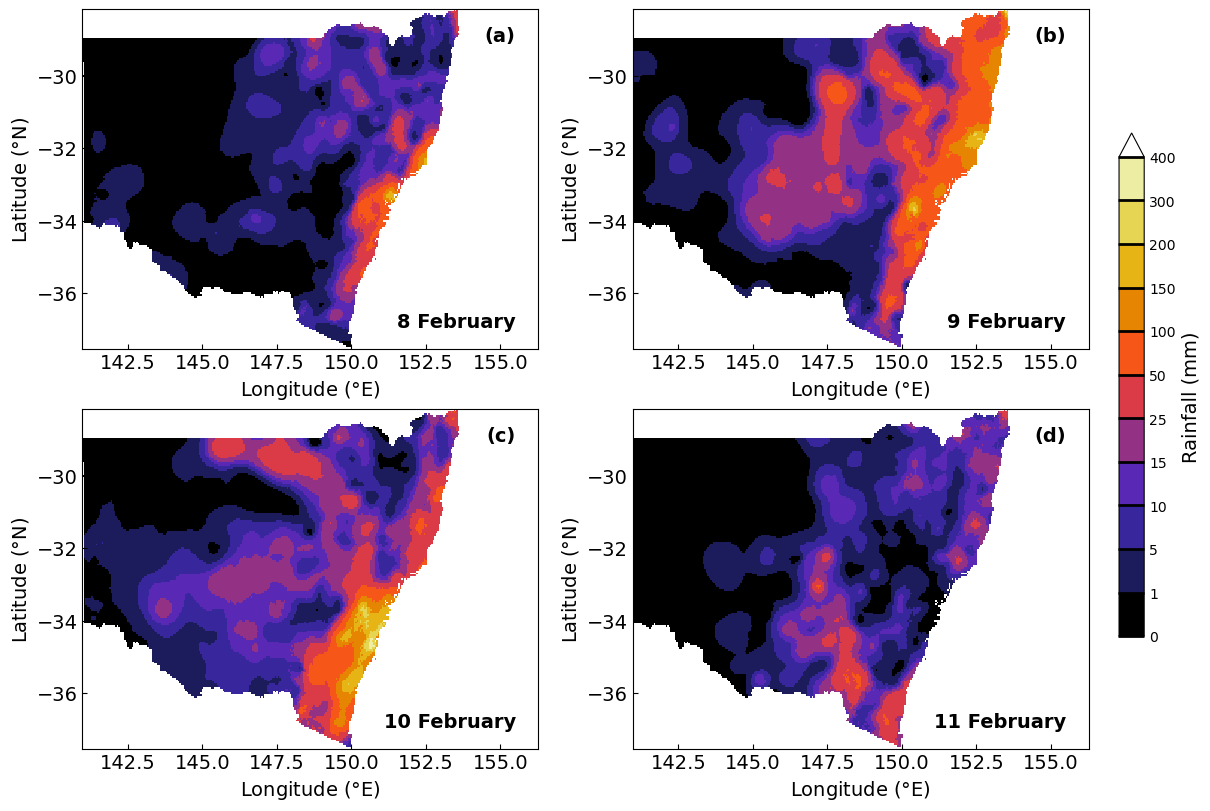

In [10]:
rain = rainfall['precip'] 
dates = ["2020-02-08", "2020-02-09", "2020-02-10", "2020-02-11"]
titles = ["8 February", "9 February", "10 February", "11 February"]
labels = ['a', 'b', 'c', 'd']

#matching the scale to the BoM's version
levels = [0, 1, 5, 10, 15, 25, 50, 100, 150, 200, 300, 400]

draft = True 

fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)

axes = axes.flatten()

#for each date from 8-11 feb, plot 
for i, date in enumerate(dates):
    masked = rain.sel(time=date).where(mask == 0)
    im = masked.plot(
        ax=axes[i],
        cmap='CMRmap',
        # cmap='gist_rainbow',
        levels=levels,
        extend='max',
        add_colorbar=False
    )
    axes[i].set_title("")
    axes[i].text(
        0.95, 0.95, f"({labels[i]})",
        transform=axes[i].transAxes,
        fontsize=14,
        fontweight='bold',
        va='top',
        ha='right'
    )
    axes[i].text(
        0.95, 0.05, f"{titles[i]}",
        transform=axes[i].transAxes,
        fontsize=14,
        fontweight='bold',
        va='bottom',
        ha='right',
    )
    axes[i].set_xlabel("Longitude ($\\degree$E)", fontsize=14)
    axes[i].set_ylabel("Latitude ($\\degree$N)", fontsize=14)
    axes[i].tick_params(axis='both', direction='in', labelsize=14)

cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.025, pad=0.02)
cbar.set_label("Rainfall (mm)", fontsize=14)
cbar.set_ticks(levels)
cbar.ax.tick_params(axis='y', width=2, direction='in', length=19)


if draft ==False:
    plt.savefig('/g/data/ng72/as9583/8_to_11_Feb_rain_event/BoM_recreation.png', dpi = 300)
    plt.savefig('/g/data/ng72/as9583/8_to_11_Feb_rain_event/BoM_recreation.pdf', dpi = 300)

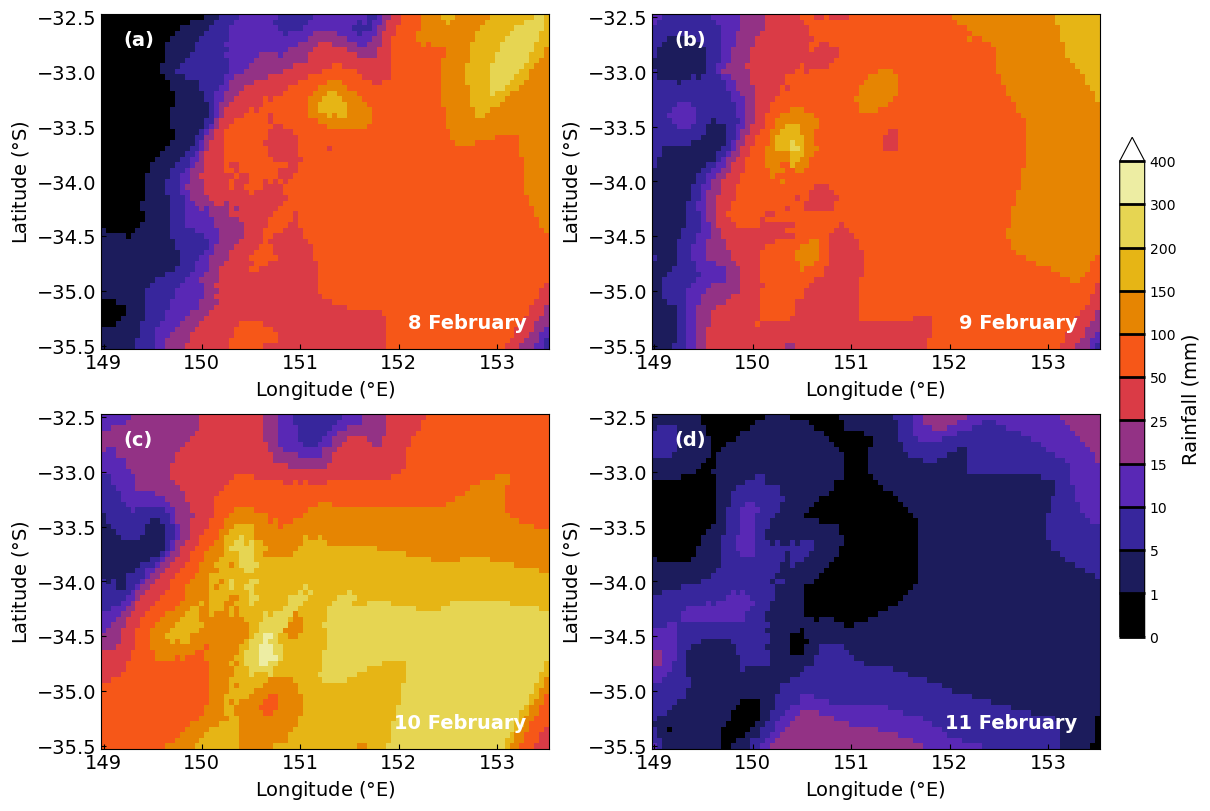

In [21]:
#showing same thing as above, but just in ACCESS-rAM3 domain
rain = rainfall['precip']

dates = ["2020-02-08", "2020-02-09", "2020-02-10", "2020-02-11"]
titles = ["8 February", "9 February", "10 February", "11 February"]
labels = ['a', 'b', 'c', 'd']

levels = [0, 1, 5, 10, 15, 25, 50, 100, 150, 200, 300, 400]

draft = True 

fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)
axes = axes.flatten()

for i, date in enumerate(dates):
    data_on_date = rain.sel(time=date)
    
    #subset to model domain
    subset = data_on_date.sel(
        lat=slice(-35.5, -32.5),
        lon=slice(149, 153.5)
    )
    
    im = subset.plot(
        ax=axes[i],
        cmap='CMRmap',
        levels=levels,
        extend='max',
        add_colorbar=False
    )
    
    axes[i].set_title("")
    axes[i].text(
        0.05, 0.95, f"({labels[i]})",
        transform=axes[i].transAxes,
        fontsize=14,
        fontweight='bold',
        va='top',
        ha='left',
        color='white'
    )
    axes[i].text(
        0.95, 0.05, f"{titles[i]}",
        transform=axes[i].transAxes,
        fontsize=14,
        fontweight='bold',
        va='bottom',
        ha='right',
        color='white'
    )
    axes[i].set_xlabel("Longitude ($\\degree$E)", fontsize=14)
    axes[i].set_ylabel("Latitude ($\\degree$S)", fontsize=14)
    axes[i].tick_params(axis='both', direction='in', labelsize=14)

cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.025, pad=0.02)
cbar.set_label("Rainfall (mm)", fontsize=14)
cbar.set_ticks(levels)
cbar.ax.tick_params(axis='y', width=2, direction='in', length=19)

if draft ==False:
    plt.savefig('/g/data/ng72/as9583/8_to_11_Feb_rain_event/BoM_recreation_modeldomain.png')
    plt.savefig('/g/data/ng72/as9583/8_to_11_Feb_rain_event/BoM_recreation_modeldomain.pdf', dpi = 300)


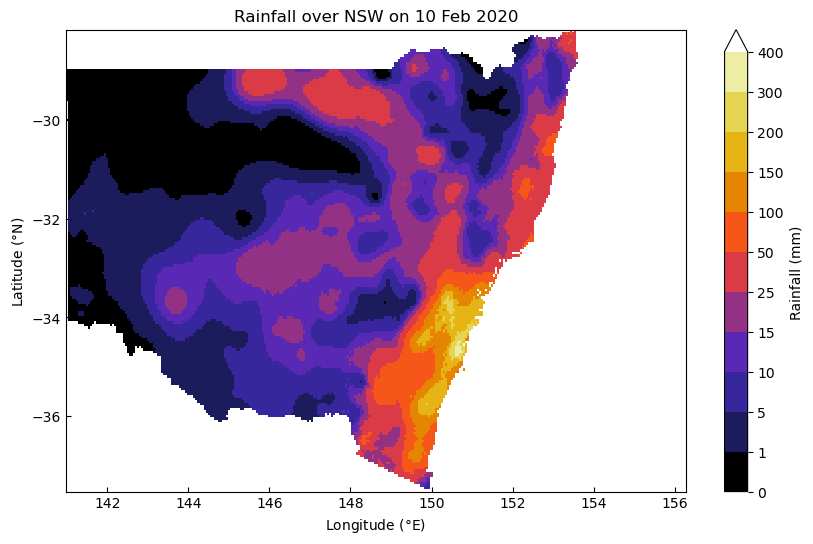

In [17]:
#testing to look at the big rainfall day
rain_feb10 = rain.sel(time="2020-02-10")
feb10_masked = rain_feb10.where(mask == 0)

levels = [0, 1, 5, 10, 15, 25, 50, 100, 150, 200, 300, 400]

plt.figure(figsize=(10, 6))
im = feb10_masked.plot(
    cmap='CMRmap',
    levels=levels,
    extend='max', 
    cbar_kwargs={"ticks": levels, "label": "Rainfall (mm)"}
)
im.axes.set_xlabel("Longitude ($\\degree$E)")
im.axes.set_ylabel("Latitude ($\\degree$N)")
im.axes.tick_params(axis='both', direction='in')
plt.title("Rainfall over NSW on 10 Feb 2020")
plt.show()


In [19]:
feb10_masked.max()

<xarray.DataArray 'precip' ()> Size: 8B
array(368.79882812)
Coordinates:
    crs      int64 8B 0